In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import Adam, lr_scheduler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import os
import time
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [3]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CSV file which holds the paths for all the images
veg_file_path = '/content/sample_data/Leafy_testing_new_2306_v1.csv'
data = pd.read_csv(veg_file_path)

# Initialize the Label Encoder & Label encoding for the training data
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

# Print the mapping of labels to codes
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label to Code Mappings:")
for label, code in label_mapping.items():
    print(f"{label}: {code}")

# Split the data into training, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.1, stratify=data['Label'], random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['Label'], random_state=42)

print(f"Training set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

Label to Code Mappings:
Day01: 0
Day02: 1
Day03: 2
Training set: 1822 samples
Validation set: 456 samples
Test set: 254 samples


In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        self.img_labels = annotations_file
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
# Define data transformations
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# Create datasets
train_dataset = CustomImageDataset(train_data, transform=train_transform)
val_dataset = CustomImageDataset(val_data, transform=val_transform)
test_dataset = CustomImageDataset(test_data, transform=val_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the number of samples
print(f'Training samples: {len(train_loader.dataset)}')
print(f'Validation samples: {len(val_loader.dataset)}')
print(f'Test samples: {len(test_loader.dataset)}')

Training samples: 1822
Validation samples: 456
Test samples: 254


In [7]:
# Print the number of samples
print(f'Training samples: {len(train_loader)}')
print(f'Validation samples: {len(val_loader)}')
print(f'Test samples: {len(test_loader)}')

Training samples: 57
Validation samples: 15
Test samples: 8


In [8]:
#Calculate number of classes
num_classes = len(data['Label'].unique())

def get_densenet_model(model_name, num_classes):
    if model_name == 'densenet121':
        model = models.densenet121(pretrained=True)
    elif model_name == 'densenet201':
        model = models.densenet201(pretrained=True)
    else:
        raise ValueError("Invalid model name. Choose either 'densenet121' or 'densenet201'.")

    for param in model.parameters():
        param.requires_grad = False

    for param in model.features.denseblock3.parameters():
        param.requires_grad = True
    for param in model.features.denseblock4.parameters():
        param.requires_grad = True

    num_features = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes),
        nn.LogSoftmax(dim=1)
    )

    model = model.to(device)
    return model

criterion = nn.CrossEntropyLoss()

class EarlyStopping:
    def __init__(self, patience=15, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            if self.best_loss == float('inf'):
                print(f'Validation loss: {val_loss:.6f}.  Saving model ...')
            else:
                print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.best_loss = val_loss
        torch.save(model.state_dict(), 'checkpoint.pth')

def train_model(model, criterion, optimizer, scheduler, early_stopping, train_loader, val_loader, num_epochs=100):
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_accuracy = val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_accuracy.append(val_epoch_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}.. "
              f"Train loss: {epoch_loss:.4f}.. "
              f"Train accuracy: {epoch_accuracy*100:.2f}%.. "
              f"Val loss: {val_epoch_loss:.4f}.. "
              f"Val accuracy: {val_epoch_accuracy*100:.2f}%")

        scheduler.step(val_epoch_loss)
        early_stopping(val_epoch_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 88.0MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  w

Epoch 1/100.. Train loss: 0.9989.. Train accuracy: 52.58%.. Val loss: 1.0685.. Val accuracy: 63.82%
Validation loss: 1.068479.  Saving model ...
Epoch 2/100.. Train loss: 0.7118.. Train accuracy: 69.70%.. Val loss: 0.7286.. Val accuracy: 73.03%
Validation loss decreased (1.068479 --> 0.728618).  Saving model ...
Epoch 3/100.. Train loss: 0.5750.. Train accuracy: 76.51%.. Val loss: 0.4793.. Val accuracy: 81.80%
Validation loss decreased (0.728618 --> 0.479257).  Saving model ...
Epoch 4/100.. Train loss: 0.4759.. Train accuracy: 80.57%.. Val loss: 0.3601.. Val accuracy: 87.06%
Validation loss decreased (0.479257 --> 0.360086).  Saving model ...
Epoch 5/100.. Train loss: 0.4237.. Train accuracy: 82.27%.. Val loss: 0.3774.. Val accuracy: 83.55%
EarlyStopping counter: 1 out of 10
Epoch 6/100.. Train loss: 0.4287.. Train accuracy: 80.85%.. Val loss: 0.2519.. Val accuracy: 90.35%
Validation loss decreased (0.360086 --> 0.251910).  Saving model ...
Epoch 7/100.. Train loss: 0.4082.. Train acc

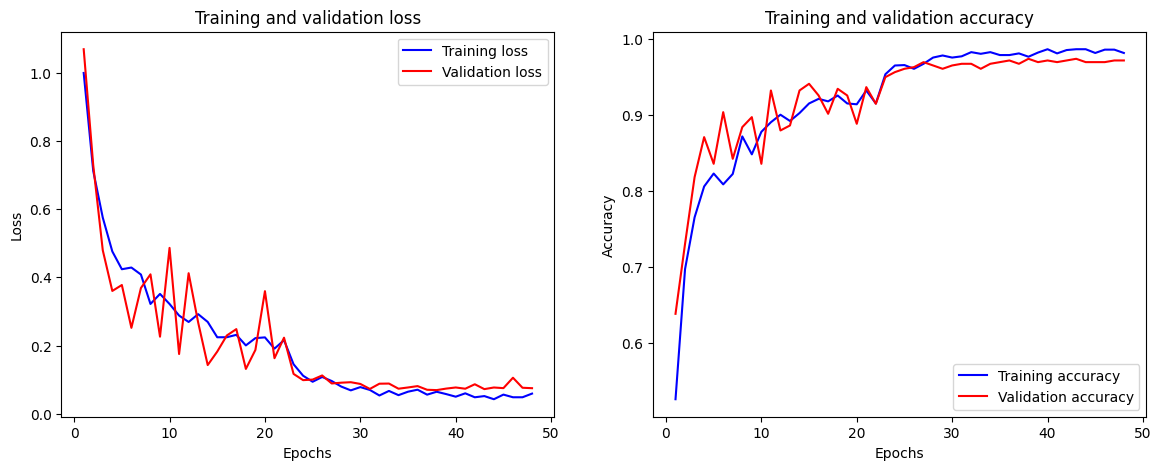

Test Loss: 0.1084, Test Accuracy: 96.46%
Test Precision: 0.9656, Test Recall: 0.9646, Test F1 Score: 0.9647
Confusion Matrix:
[[84  1  3]
 [ 1 81  3]
 [ 1  0 80]]


In [9]:
model = get_densenet_model('densenet201', num_classes)

#optimizer = Adam(model.parameters(), lr=0.001)
# Regularization with weight decay
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
early_stopping = EarlyStopping(patience=10, verbose=True)

# train_model(model, criterion, optimizer, scheduler, early_stopping, train_loader, val_loader, num_epochs=100)
# Training the model
train_model(model, criterion, optimizer, scheduler, early_stopping, train_loader, val_loader, num_epochs=100)

def evaluate_model(model, criterion, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = correct / total
    test_precision = precision_score(all_labels, all_predictions, average='weighted')
    test_recall = recall_score(all_labels, all_predictions, average='weighted')
    test_f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1 Score: {test_f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

model.load_state_dict(torch.load('checkpoint.pth'))
evaluate_model(model, criterion, test_loader)

In [10]:
# # Save the final model
# model_path = '/content/checkpoint_c.pth'
# torch.save(model.state_dict(), model_path)

# # Download the model
# from google.colab import files
# files.download(model_path1)

# Download the best model
def download_model(filepath):
    from google.colab import files
    files.download(filepath)

download_model('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>